Atividade apresentada a disciplina de Tópicos do Curso de Espoecialização em Ciência de Dados.

Giovanna Nascimento Antonieti          CP3013383

O conjunto de dados está disponível através do link https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification

# Imports

In [158]:
# !pip3 install numpy pandas scikit-learn tensorflow nltk gensim
#!conda install numpy pandas scikit-learn tensorflow nltk gensim -y


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors
import nltk
nltk.download('stopwords')
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from datetime import datetime
from nltk.tokenize import word_tokenize
#import eli5


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/giovannaantonieti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Definição das variáveis

In [ ]:
epochs=5
batch_size=128
max_words=100000
max_seq_size=256

# Funções de limpeza

Funções para remover pontuação, abreviação, emojis e caracteres especiais.

In [5]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": 
    "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", 
    "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
    "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
    "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
    "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
    "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
    "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
    "Trump's": "trump is", "Obama's": "obama is", "Canada's": "canada is", "today's": "today is"
}
    
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    words = [contraction_mapping[word] if word in contraction_mapping else word for word in text.split(" ")]
    return ' '.join(words)

In [6]:
mystopwords = set(stopwords.words("english"))

def preprocess_corpus(texts):
    def remove_stops_digits(tokens):
        return [token for token in tokens if token not in mystopwords]
    return [" ".join(remove_stops_digits(word_tokenize(content,preserve_line=True))) for content in texts]

In [7]:
specail_signs = { "…": "...", "₂": "2"}
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

def clean_special_chars(text):
    for s in specail_signs: 
        text = text.replace(s, specail_signs[s])
    for p in punct:
        text = text.replace(p, f' {p} ')
    return text

In [8]:

special_caps_mapping = { 
    "ᴀ": "a", "ʙ": "b", "ᴄ": "c", "ᴅ": "d", "ᴇ": "e", "ғ": "f", "ɢ": "g", "ʜ": "h", "ɪ": "i", "ᴊ": "j", "ᴋ": "k", "ʟ": "l", "ᴍ": "m",
    "ɴ": "n", "ᴏ": "o", "ᴘ": "p", "ǫ": "q", "ʀ": "r", "s": "s", "ᴛ": "t", "ᴜ": "u", "ᴠ": "v", "ᴡ": "w", "x": "x", "ʏ": "y", "ᴢ": "z",
    "𝘊": "C", "𝘦": "e", "𝘳": "r", "𝘢": "a", "𝘵": "t", "𝘰": "o", "𝘤": "c", "𝘺": "y", "𝘴": "s", "𝘪": "i", "𝘧": "f", "𝘮": "m", "𝘣": "b",
    "м": "m", "υ": "u", "т": "t", "ѕ": "s", "𝙀": "E", "𝒛": "z", "𝑲": "K", "𝑳": "L", "𝑾": "W", "𝒋": "j", "𝟒": "4",
    "𝙒": "W", "𝘾": "C", "𝘽": "B", "𝑱": "J", "𝑹": "R", "𝑫": "D", "𝑵": "N", "𝑪": "C", "𝑯": "H", "𝒒": "q", "𝑮": "G", "𝗕": "B", "𝗴": "g", 
    "𝟐": "2", "𝗸": "k", "𝗟": "L", "𝗠": "M", "𝗷": "j", "𝐎": "O", "𝐍": "N", "𝐊": "K", "𝑭": "F", "Е": "E"
}

def clean_small_caps(text):
    for char in special_caps_mapping:
        text = text.replace(char, special_caps_mapping[char])
    return text


In [9]:
emojis = "🍕🐵😑😢🐶️😜😎👊😁😍💖💵👎😀😂🔥😄🏻💥😋👏😱🚌ᴵ͞🌟😊😳😧🙀😐😕👍😮😃😘💩💯⛽🚄😖🏼🚲😟😈💪🙏🎯🌹😇💔😡👌🙄😠😉😤⛺🙂😏🍾🎉😞🏾😅😭👻😥😔😓🏽🎆🍻🍽🎶🌺🤔😪🐰🐇🐱🙆😨🙃💕💗💚🙈😴🏿🤗🇺🇸⤵🏆🎃😩👮💙🐾🐕😆🌠🐟💫💰💎🖐🙅⛲🍰🤐👆🙌💛🙁👀🙊🙉🚬🤓😵😒͝🆕👅👥👄🔄🔤👉👤👶👲🔛🎓😣⏺😌🤑🌏😯😲💞🚓🔔📚🏀👐💤🍇🏡❔⁉👠》🇹🇼🌸🌞🎲😛💋💀🎄💜🤢َِ🗑💃📣👿༼つ༽😰🤣🐝🎅🍺🎵🌎͟🤡🤥😬🤧🚀🤴😝💨🏈😺🌍⏏ệ🍔🐮🍁🍆🍑🌮🌯🤦🍀😫🤤🎼🕺🍸🥂🗽🎇🎊🆘🤠👩🖒🚪🇫🇷🇩🇪😷🇨🇦🌐📺🐋💘💓💐🌋🌄🌅👺🐷🚶🤘ͦ💸👂👃🎫🚢🚂🏃👽😙🎾👹⎌🏒⛸🏄🐀🚑🤷🤙🐒🐈ﷻ🦄🚗🐳👇⛷👋🦊🐽🎻🎹⛓🏹🍷🦆♾🎸🤕🤒⛑🎁🏝🦁🙋😶🔫👁💲🗯👑🚿💡😦🏐🇰🇵👾🐄🎈🔨🐎🤞🐸💟🎰🌝🛳🍭👣🏉💭🎥🐴👨🤳🦍🍩😗🏂👳🍗🕉🐲🍒🐑⏰💊🌤🍊🔹🤚🍎𝑷🐂💅💢💒🚴🖕🖤🥘📍👈➕🚫🎨🌑🐻🤖🎎😼🕷👼📉🍟🍦🌈🔭《🐊🐍🐦🐡💳ἱ🙇🥜🔼"

def remove_emojis(text):
    for emoji in emojis:
        text = text.replace(emoji, '')
    return text

In [10]:
def clean_process(text):
    text = text.lower()
    text = clean_contractions(text)
    text = clean_special_chars(text)
    text = clean_small_caps(text)
    return text

In [11]:
def print_report(pipe, x_test, y_test):
    y_pred = pipe.predict(x_test)
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

# Dados

In [12]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [13]:
train.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [14]:
train.shape

(1804874, 45)

In [15]:
train = train[['target','comment_text']]

In [16]:
train.head(5)

,target,comment_text
0,0.000000,"This is so cool. It's like, 'would you want yo..."
1,0.000000,Thank you!! This would make my life a lot less...
2,0.000000,This is such an urgent design problem; kudos t...
3,0.000000,Is this something I'll be able to install on m...
4,0.893617,haha you guys are a bunch of losers.


In [22]:
dateTimeObj = datetime.now()
print("Treino início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)


train['comment_text'] = train['comment_text'].apply(lambda text: clean_process(text))

dateTimeObj = datetime.now()
print("Teste início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)


test['comment_text'] = test['comment_text'].apply(lambda text: clean_process(text))

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)



y = train['target']
y = np.where(y>=0.5,1,0)
y[:5]

Treino início:  17 : 21 : 27
Teste início:  17 : 22 : 3
Fim:  17 : 22 : 5


array([0, 0, 0, 0, 1])

In [25]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

X_stopwords = preprocess_corpus(train['comment_text'])

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  17 : 25 : 27
Fim:  17 : 29 : 1


In [26]:
print(np.shape(train['comment_text']))

(1804874,)


In [27]:
print(np.shape(X_stopwords))

(1804874,)


In [28]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

X_test_stopwords = preprocess_corpus(test['comment_text'])

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  17 : 29 : 3
Fim:  17 : 29 : 15


In [30]:
print(np.shape(test['comment_text']))

(97320,)


In [31]:
print(np.shape(X_test_stopwords))

(97320,)


## Tokenização

In [32]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

tranformer = Tokenizer(lower = True, filters='', num_words=max_words)
tranformer.fit_on_texts( list(X_stopwords) + list(X_test_stopwords) )
transformed_x = tranformer.texts_to_sequences(X_stopwords)
transformed_x = pad_sequences(transformed_x, maxlen = max_seq_size)

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  17 : 29 : 32
Fim:  17 : 30 : 29


In [34]:
X_test = tranformer.texts_to_sequences(X_test_stopwords)
X_test = pad_sequences(X_test, maxlen = max_seq_size)

In [35]:
dateTimeObj = datetime.now()
print("Início: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

X_train, X_val, y_train, y_val = train_test_split(transformed_x, y, test_size=0.2, random_state=42)

dateTimeObj = datetime.now()
print("Fim: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

Início:  17 : 31 : 10
Fim:  17 : 31 : 15


In [36]:
neg_class_len = np.sum(y_train)
pos_class_len =train.shape[0] - int(neg_class_len)
print('negitive (1) class len is :',int(neg_class_len))
print('positive (0) class len is :',pos_class_len)

negitive (1) class len is : 115256
positive (0) class len is : 1689618


In [38]:
np.save("./numpy_arrays/X_train.npy", np.asarray(X_train))
np.save("./numpy_arrays/Y_train.npy", np.asarray(y_train))
np.save("./numpy_arrays/X_val.npy", np.asarray(X_val))
np.save("./numpy_arrays/Y_val.npy", np.asarray(y_val))
np.save("./numpy_arrays/X_test.npy", np.asarray(X_test))


# Modelos Clássicos

## Regressão Logística

In [159]:
lr = LogisticRegression(max_iter=200)

In [161]:
dateTimeObj = datetime.now()
print("Início treinamento: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

lr.fit(X_train, y_train)

dateTimeObj = datetime.now()
print("Fim treinamento: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)


print_report(lr, X_val, y_val)

Início treinamento:  7 : 36 : 6


/opt/homebrew/Caskroom/miniforge/base/envs/topicos/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fim treinamento:  7 : 40 : 44
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    331897
           1       0.06      0.00      0.00     29078

    accuracy                           0.92    360975
   macro avg       0.49      0.50      0.48    360975
weighted avg       0.85      0.92      0.88    360975

accuracy: 0.919


## Regressão SVM

In [162]:
svm = LinearSVC(max_iter=200)

In [164]:
dateTimeObj = datetime.now()
print("Início treinamento: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

svm.fit(X_train, y_train)

dateTimeObj = datetime.now()
print("Fim treinamento: ", dateTimeObj.hour, ':', dateTimeObj.minute, ':', dateTimeObj.second)

print_report(svm, X_val, y_val)

Início treinamento:  7 : 42 : 55


/opt/homebrew/Caskroom/miniforge/base/envs/topicos/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fim treinamento:  7 : 44 : 50
              precision    recall  f1-score   support

           0       0.92      0.75      0.83    331897
           1       0.08      0.24      0.12     29078

    accuracy                           0.71    360975
   macro avg       0.50      0.50      0.47    360975
weighted avg       0.85      0.71      0.77    360975

accuracy: 0.710


# Rede Neural

In [185]:
import tensorflow
sequence_input = tensorflow.keras.layers.Input(shape=(max_seq_size,), dtype='int32')
model = tensorflow.keras.models.Sequential()
model.add(tensorflow.keras.layers.Embedding(total_vocab,
                            50,
                            input_length=max_seq_size));
model.add(tensorflow.keras.layers.LSTM(64));

model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 256, 50)           16070600  
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,100,105
Trainable params: 16,100,105
Non-trainable params: 0
_________________________________________________________________


In [186]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [192]:
callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(patience=3, verbose=1)]

In [193]:
history = None
with tensorflow.device('/GPU:0'):
    history = model.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=10,
                    validation_data=(X_val, y_val), 
                    callbacks=callbacks)

Epoch 1/10
2821/2821 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9464WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x32a5e10d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ('self',)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2821/2821 [==============================] - 1711s 607ms/

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 4.13.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: 'acc'

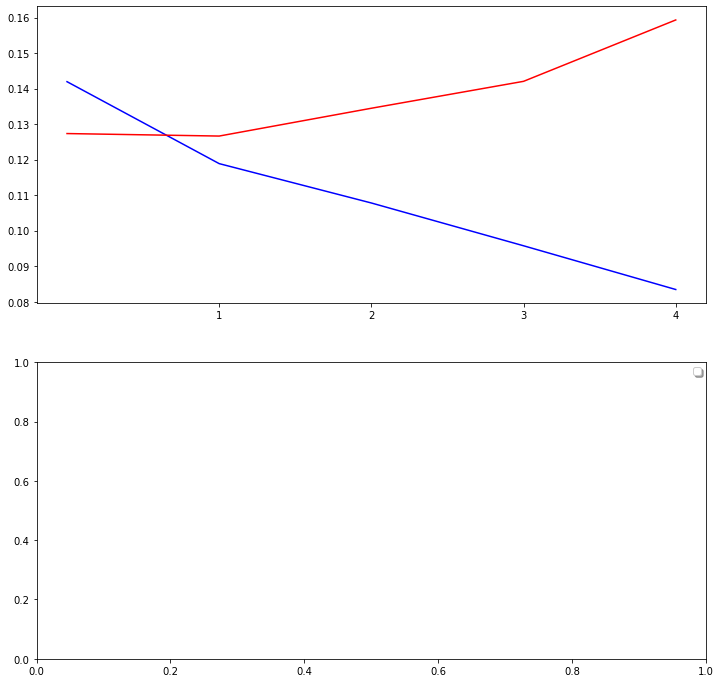

In [194]:
!conda install matplotlib -y
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
plt.legend(loc='best', shadow=True)

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
print_report(model, X_val, y_val)